# inicialização

In [50]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
from sympy import symbols, pprint
import matplotlib.pyplot as plt
import plotly.express as px
import os
import sys

sys.path.append("..")

from structureSelector import *
from structureSelector2 import structureSelectorV2
from methods.utils.utilities import *

def metrics(y, yest):
    residuo1 = y - yest
    index = np.where(y != 0)
    mape = round(np.mean(np.abs(residuo1[index] / y[index])) * 100, 3)
    mse = np.mean(np.square(residuo1))
    rmse = np.sqrt(mse)
    aet = np.sum(np.abs(residuo1))
    print('RMSE:', round(rmse, 4),'\nMSE:', round(mse, 4), '\nAET:', round(aet, 4), '\nMAPE:', str(round(mape, 5)) + '%')
    coeficiente_corr = np.corrcoef(y, yest)[0, 1]
    print("Coeficiente de correlação:", coeficiente_corr)
    #print(y.shape, yest.shape)

mat_content1 = sc.loadmat("../data/DATAPRBS.MAT")

u1 = mat_content1['u2']
z1 = mat_content1['z2'] / 5.5

zc1 = z1.copy()
l1 = np.array([33, 57, 77, 92, 107, 133, 162, 197, 232, 273, 293, 307, 337, 372, 388, 407, 437, 452, 473])
l2 = np.array([47, 63, 83, 99, 116, 153, 172, 223, 241, 287, 299, 314, 368, 382, 402, 422, 443, 467, 500])

for i in range(l1.shape[0]):
    zc1[l1[i]: l2[i]] *= -1

t = np.arange(0, 500, 1)#np.arange(0, 10, 0.02)
fig=px.line(x=t, y=np.squeeze(z1), height=400, width=1300)
fig.add_scatter(x=t, y=np.squeeze(zc1), mode='lines')
fig.add_scatter(x=t, y=np.squeeze(u1), mode='lines')
fig.show()


In [ ]:
p = np.arange(0, 10, 0.02)
f, ax = plt.subplots(2, 1, figsize=[14, 6])
ax[0].plot(p, u1, label='Entrada')

ax[1].plot(p, z1, label='Saída')
plt.show()

In [ ]:
Y = np.zeros(z1.shape)
U = u1.copy()
Ts = 0.02

x1 = np.zeros(z1.shape)
x2 = np.zeros(z1.shape)
x3 = np.zeros(z1.shape)

c = np.array([[5017, -19.61, -504.2, -2747],
              [4015, -17.96, -463.7, -2094],
               [5174, -20.52, -512.5, -2931]])
j = 2
for i in range(1, z1.shape[0]):
    dx3 = c[j][0] * U[i-1] + c[j][1] * x3[i-1] + c[j][2] * x2[i-1] + c[j][3] * x1[i-1]
    x3[i] = x3[i-1] + Ts * dx3
    x2[i] = x2[i-1] + Ts * x3[i][0]
    x1[i] = x1[i-1] + Ts * x2[i][0]
    
    
zc1[32:47] *= -1
zc1[56:64] *= -1
zc1[75:83] *= -1
zc1[91:99] *= -1
zc1[107:116] *= -1
zc1[132:153] *= -1
zc1[161:172] *= -1
zc1[196:223] *= -1
zc1[231:241] *= -1
zc1[272:286] *= -1
zc1[292:299] *= -1
zc1[307:314] *= -1
zc1[337:368] *= -1
zc1[372:382] *= -1
zc1[388:401] *= -1
zc1[407:422] *= -1
zc1[436:443] *= -1
zc1[452:466] *= -1
zc1[472:] *= -1

tt = np.arange(0, 10, 0.02)
plt.figure(figsize=(14,3))
plt.plot(tt, zc1, label='Original')
#plt.plot(x1, label='Original')
s = np.sin(t/3 - np.pi/3) + x1[:, 0]
plt.plot(tt, x1)
plt.hlines(y=0, xmin=0, xmax=10, color='black')
plt.show()

# Estimação PRBS

In [11]:
output = 0  # 0 ou 1

y = zc1.copy()
u = u1.copy()
num = [9, 6]
params = []
params.append({'nb':[6],'na':[8], 'level':2, 'nonlinear':[0, 0, 0, 1, 0], 'root':False, 'delay':0, 'diff':False}) #9
#params.append({'nb':[2],'na':[6], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':2, 'diff':False}) #zc1 5
#params.append({'nb':[4],'na':[6], 'level':1,2
sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)

vCandidatos = sselector.matrix_candidate(u.T, y.T, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[pad:, output], num[output], 0.000001)
theta = LSM(y[pad:, output], psi)
model = ss[selected]
#theta[2] = theta[3]
print(model, theta)
print(model @ theta)

slivre = sselector.predict(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)
yhat = sselector.oneStepForward(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1, intg=False)


fim = -1
s = 0#t-20
ts = np.arange(0, 10, 0.02)
plt.figure(figsize=(12,3))
plt.plot(ts, y, label='Original')
plt.plot(ts[s:fim], slivre[s:fim], label='Livre')
plt.hlines([3, 0, -3], 0, 10, colors='black')

plt.legend()
plt.show()

print("\nSimulação livre")
metrics(y[:, 0], slivre)
print("\nUm passo a frente")
metrics(y[:, 0], yhat)

'''plt.plot(y[:, 0] - yhat, label='Livre')
plt.legend()
plt.show()'''


LinAlgError: Singular matrix

## view

In [ ]:
n = 1
u2 = mat_content1['u'+str(n)]
z2 = mat_content1['z'+str(n)]

t = np.arange(0, 500, 1)#np.arange(0, 10, 0.02)
fig=px.line(x=t, y=np.squeeze(z2), height=400, width=1300)
#fig.add_scatter(x=t, y=np.squeeze(x1), mode='lines')
fig.add_scatter(x=t, y=np.squeeze(u2), mode='lines')
#fig.add_scatter(x=t, y=np.squeeze(u1), mode='lines')
fig.show()

## Validação

In [ ]:
uVal = u2.T
#uVal[0, 25:35] = -0.75
yVal = z2.copy().T
#yVal[0, :10] = 0
yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)

print("Modelo selecionado:")
pprint( model @ theta)

f, ax = plt.subplots(2, 1, figsize=[16,5])
ax[0].plot(yVal[output].T, label='Original')
ax[0].plot(np.abs(valLivre), label='Livre')
#ax[0].plot(yhat, label='um passo a frente')
ax[0].hlines(1.25, 0, 500)
ax[0].set_title("Simulações")
ax[0].legend()

ax[1].plot(yVal[output].T - np.abs(valLivre), label='Livre')
ax[1].plot(yVal[output].T - yhat, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

print("\nSimulação livre")
metrics(yVal[0, :], valLivre)
print("\nUm passo a frente")
metrics(yVal[0, :], yhat)


# Uniform

## preparação

In [12]:
mat_content2 = sc.loadmat("../data/DATAUNIF.MAT")

print(mat_content2.keys())
u11 = mat_content2['u11']
z11 = mat_content2['z11']

u12 = mat_content2['u12']
z12 = mat_content2['z12']


t = np.arange(0, 500, 1)#np.arange(0, 10, 0.02)
fig=px.line(x=t, y=np.squeeze(z11), height=400, width=1300)
fig.add_scatter(x=t, y=np.squeeze(u11), mode='lines')
#fig.add_scatter(x=t, y=np.squeeze(zc11), mode='lines')

fig.show()
'''fig=px.line(x=t, y=np.squeeze(z12), height=400, width=1300)
fig.add_scatter(x=t, y=np.squeeze(z12), mode='lines')
fig.add_scatter(x=t, y=np.squeeze(u12), mode='lines')
fig.show()'''

dict_keys(['u11', 'u12', 'z11', 'z12'])


"fig=px.line(x=t, y=np.squeeze(z12), height=400, width=1300)\nfig.add_scatter(x=t, y=np.squeeze(z12), mode='lines')\nfig.add_scatter(x=t, y=np.squeeze(u12), mode='lines')\nfig.show()"

In [18]:
'''Y = np.zeros(z11.shape)
U = u12.copy()
Ts = 0.02

x1 = np.zeros(z1.shape)
x2 = np.zeros(z1.shape)
x3 = np.zeros(z1.shape)

c = np.array([[2132, -24.83, -548.0, -2609],
                [2567, -23.93, -627.4, -3293],
                [2922, -27.09, -668.9, -3834],
                [4186, -41.64, -870.8, -5684],
                [10370, -124.9, -2694, -23220]])
j = 2
for i in range(1, z1.shape[0]):
    dx3 = c[j][0] * U[i-1] + c[j][1] * x3[i-1] + c[j][2] * x2[i-1] + c[j][3] * x1[i-1]
    x3[i] = x3[i-1] + Ts * dx3
    x2[i] = x2[i-1] + Ts * x3[i][0]
    x1[i] = x1[i-1] + Ts * x2[i][0]

tt = np.arange(0, 10, 0.02)
plt.figure(figsize=(14,3))
plt.plot(tt, zc12, label='Original')
plt.plot(tt, x1)
plt.hlines(y=0, xmin=0, xmax=10, color='black')
plt.show() '''

"Y = np.zeros(z11.shape)\nU = u12.copy()\nTs = 0.02\n\nx1 = np.zeros(z1.shape)\nx2 = np.zeros(z1.shape)\nx3 = np.zeros(z1.shape)\n\nc = np.array([[2132, -24.83, -548.0, -2609],\n                [2567, -23.93, -627.4, -3293],\n                [2922, -27.09, -668.9, -3834],\n                [4186, -41.64, -870.8, -5684],\n                [10370, -124.9, -2694, -23220]])\nj = 2\nfor i in range(1, z1.shape[0]):\n    dx3 = c[j][0] * U[i-1] + c[j][1] * x3[i-1] + c[j][2] * x2[i-1] + c[j][3] * x1[i-1]\n    x3[i] = x3[i-1] + Ts * dx3\n    x2[i] = x2[i-1] + Ts * x3[i][0]\n    x1[i] = x1[i-1] + Ts * x2[i][0]\n\ntt = np.arange(0, 10, 0.02)\nplt.figure(figsize=(14,3))\nplt.plot(tt, zc12, label='Original')\nplt.plot(tt, x1)\nplt.hlines(y=0, xmin=0, xmax=10, color='black')\nplt.show() "

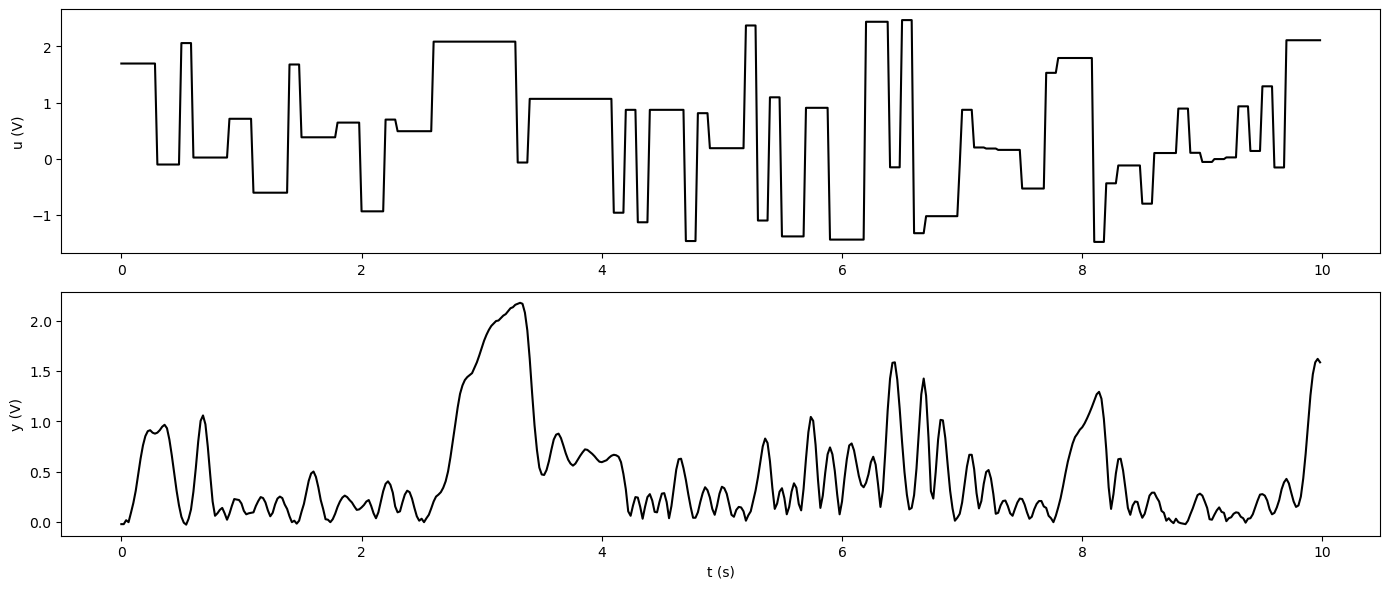

In [13]:
p = np.arange(0, 10, 0.02)

f, ax = plt.subplots(2, 1, figsize=[14, 6])
ax[0].plot(p, u11, label='Entrada', color='black')
ax[0].set_ylabel('u (V)')

ax[1].plot(p, z11, label='Saída', color='black')
ax[1].set_ylabel('y (V)')
ax[1].set_xlabel('t (s)')


plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Modelo TCC - Jonh lucas/figuras/coupledrives.png')

plt.show()


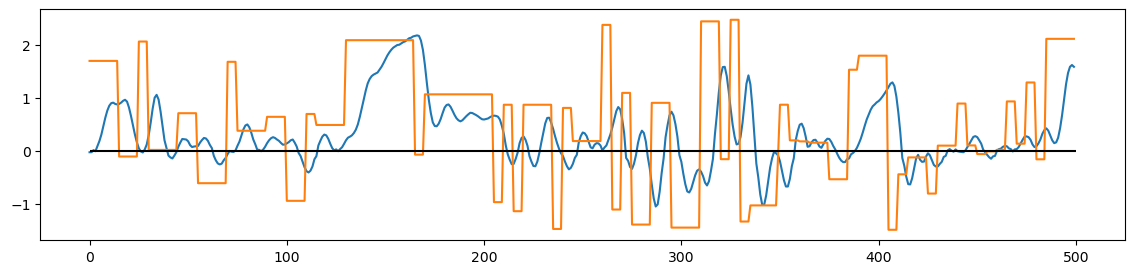

In [14]:
zc11 = z11.copy()

l1 = np.array([40, 63, 106, 212, 223, 239, 272, 283, 299, 338, 379, 412, 454])
l2 = np.array([45, 73, 116, 218, 229, 248, 278, 292, 317, 358, 389, 435, 460])
'''
l1 = np.array([40, 63, 106, 212, 223, 239, 272, 283, 299, 338, 379, 412, 454, 480])
l2 = np.array([45, 73, 116, 218, 229, 248, 278, 292, 317, 347, 389, 435, 460, 490])

l1 = np.array([40, 63, 106, 212, 223, 239, 272, 283, 299, 338, 379, 412, 454])
l2 = np.array([45, 73, 116, 218, 229, 248, 278, 292, 317, 357, 389, 435, 460])
'''

for i in range(l1.shape[0]):
    zc11[l1[i]: l2[i]] *= -1

plt.figure(figsize=(14,3))
plt.plot(zc11)
plt.plot(u11)
plt.hlines(0, 0, 500, colors='black')
plt.show()

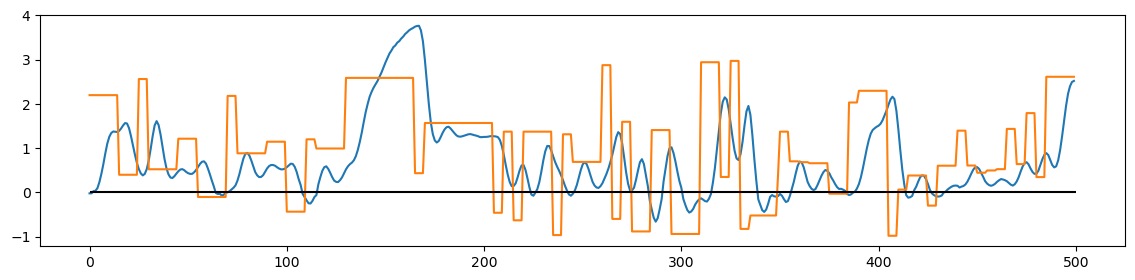

In [15]:
zc12 = z12.copy()
l1 = np.array([64, 108, 224, 243, 284, 301, 339, 384, 414, 427])
l2 = np.array([71, 116, 227, 246, 291, 316, 356, 388, 418, 434])

for i in range(l1.shape[0]):
    zc12[l1[i]: l2[i]] *= -1

plt.figure(figsize=(14,3))
plt.plot(zc12)
plt.plot(u12)
plt.hlines(0, 0, 500, colors='black')
plt.show()

## Teste

In [ ]:
output = 0  # 0 ou 1

y = zc11.copy()
u = u11.copy()
num = [12, 9]
params = []
params.append({'nb':[6],'na':[6], 'level':2, 'nonlinear':[0,0,0,1,0], 'root':False, 'delay':0, 'diff':False}) #9

#params.append({'nb':[6],'na':[8], 'level':2, 'nonlinear':[0,0,0,1,0], 'root':False, 'delay':0, 'diff':False}) #9

sselector = structureSelectorV2()
ss = sselector.symbolic_regressors(**params[output], intg=False)
#print(ss)

vCandidatos = sselector.matrix_candidate(u.T, y.T, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[pad:, output], num[output], 0.000001)
theta = LSM(y[pad:, output], psi)
model = ss[selected]

print(model, theta)
print(model @ np.round(theta, 5))

slivre = sselector.predict(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)
yhat = sselector.oneStepForward(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1, intg=False)

fim = -1
s = 0#t-20
ts = np.arange(0, 10, 0.02)
plt.figure(figsize=(12,3))
plt.plot(ts, y, label='Original')
#plt.plot(ts[s:fim], yhat[s:fim], label='um passo a frente')
plt.plot(ts[s:fim], slivre[s:fim], label='Livre')
plt.hlines([1.5, 0, -1.5], 0, 10, colors='black')
plt.plot(ts, u, label='Entrada')
plt.legend()
plt.show()

print("\nUm passo a frente")
metrics(y[:, 0], yhat)
print("\nSimulação livre")
metrics(y[:, 0], slivre)

## Estimação

### Absoluto

[1 Y1.1 Y1.2 ... U1.7**2*tanh(U1.1)**2 U1.7*tanh(U1.1)**3 tanh(U1.1)**4]
[Y1.1 Y1.2 U1.4*U1.7 Y1.4 U1.5**2 U1.4*U1.7*Y1.2*tanh(U1.1)] [ 1.75582212 -1.07869043  0.01940477  0.2258787   0.01596651  0.0065548 ]
0.00655*U1.4*U1.7*Y1.2*tanh(U1.1) + 0.0194*U1.4*U1.7 + 0.01597*U1.5**2 + 1.75582*Y1.1 - 1.07869*Y1.2 + 0.22588*Y1.4
Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7]


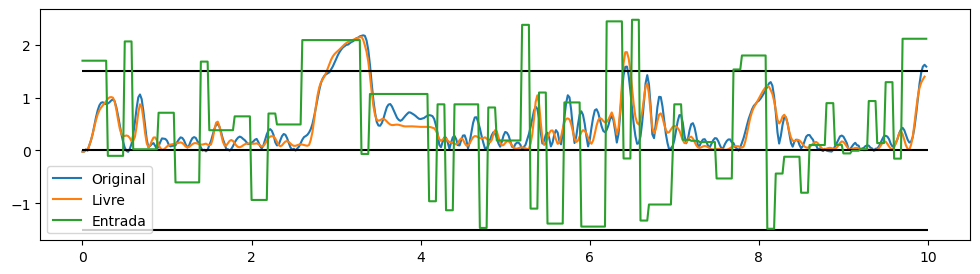


Um passo a frente
RMSE: 0.0444 
MSE: 0.002 
AET: 15.47 
MAPE: 58.279%
Coeficiente de correlação: 0.9958900322484213

Simulação livre
RMSE: 0.1535 
MSE: 0.0236 
AET: 59.137 
MAPE: 121.588%
Coeficiente de correlação: 0.9538773975057118
Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7]
Modelo selecionado:
                                                                2             
0.0066⋅U1.4⋅U1.7⋅Y1.2⋅tanh(U1.1) + 0.0194⋅U1.4⋅U1.7 + 0.016⋅U1.5  + 1.7558⋅Y1.

                             
1 - 1.0787⋅Y1.2 + 0.2259⋅Y1.4


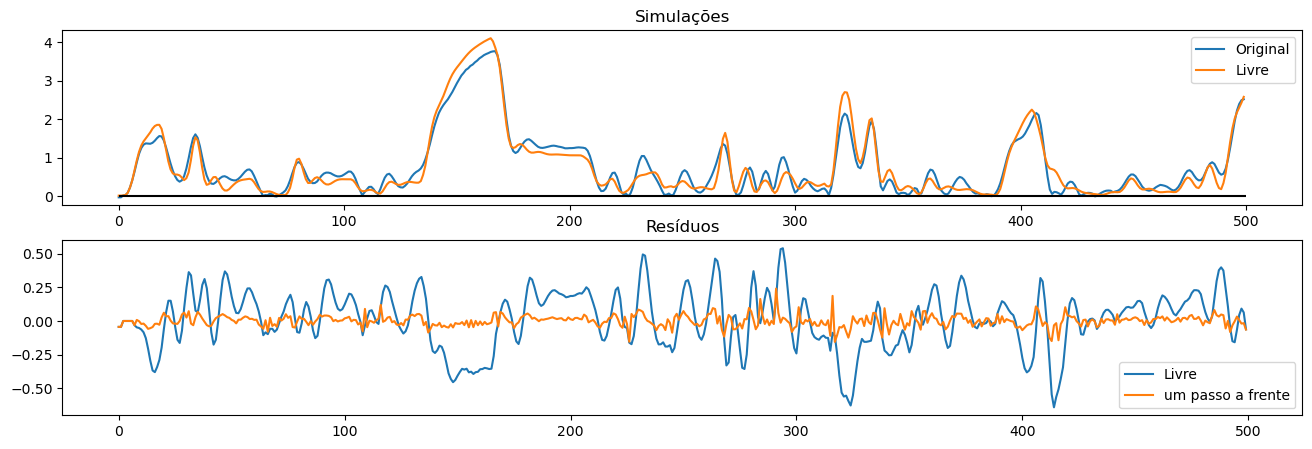


Um passo a frente
RMSE: 0.0434 
MSE: 0.0019 
AET: 15.957 
MAPE: 28.392%
Coeficiente de correlação: 0.9985599339695741

Simulação livre
RMSE: 0.2095 
MSE: 0.0439 
AET: 83.2084 
MAPE: 71.372%
Coeficiente de correlação: 0.9735481545577213


In [22]:
output = 0  # 0 ou 1

y = z11.copy()
u = u11.copy()
num = [8]
params = []
params.append({'nb':[4],'na':[7], 'level': 4, 'nonlinear':[0, 0, 0, 1, 0], 'root':False, 'delay':0, 'diff':False}) #9

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)
print(ss)

vCandidatos = sselector.matrix_candidate(u.T, y.T, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[pad:, output], num[output], 0.000001)
theta = LSM(y[pad:, output], psi)
model = ss[selected]

print(model, theta)
print(model @ np.round(theta, 5))

slivre = sselector.predict(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)
yhat = sselector.oneStepForward(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1, intg=False)

fim = -1
s = 0#t-20
ts = np.arange(0, 10, 0.02)
plt.figure(figsize=(12,3))
plt.plot(ts, y, label='Original')
#plt.plot(ts[s:fim], yhat[s:fim], label='um passo a frente')
plt.plot(ts[s:fim], slivre[s:fim], label='Livre')
plt.hlines([1.5, 0, -1.5], 0, 10, colors='black')
plt.plot(ts, u, label='Entrada')
plt.legend()
plt.show()

print("\nUm passo a frente")
metrics(y[:, 0], yhat)
print("\nSimulação livre")
metrics(y[:, 0], slivre)

uVal = u12.T
yVal = z12.T

yValHat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)

print("Modelo selecionado:")
pprint( model @ np.round(theta, 4))

f, ax = plt.subplots(2, 1, figsize=[16,5])
ax[0].plot(yVal[output].T, label='Original')
#ax[0].plot(valLivre, label='Livre')
ax[0].plot(np.abs(valLivre), label='Livre')
#ax[0].plot(yhat, label='um passo a frente')
ax[0].hlines(0, 0, 500, colors='black')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - np.abs(valLivre), label='Livre')
ax[1].plot(yVal[output].T - np.abs(yValHat), label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

print("\nUm passo a frente")
metrics(yVal[0, :], np.abs(yValHat))
print("\nSimulação livre")
metrics(yVal[0, :], np.abs(valLivre))

### não absoluto

[Y1.1 U1.4 Y1.6 U1.3*U1.7**2 Y1.3 U1.5*U1.8*Y1.6 U1.6 Y1.6*tanh(Y1.1)] [ 1.27475978  0.02957576  0.10085383  0.00635724 -0.51144548  0.00709624
  0.01878152  0.03842272]
0.00636*U1.3*U1.7**2 + 0.02958*U1.4 + 0.0071*U1.5*U1.8*Y1.6 + 0.01878*U1.6 + 1.27476*Y1.1 - 0.51145*Y1.3 + 0.03842*Y1.6*tanh(Y1.1) + 0.10085*Y1.6
Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, Y1.5, Y1.6, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8]


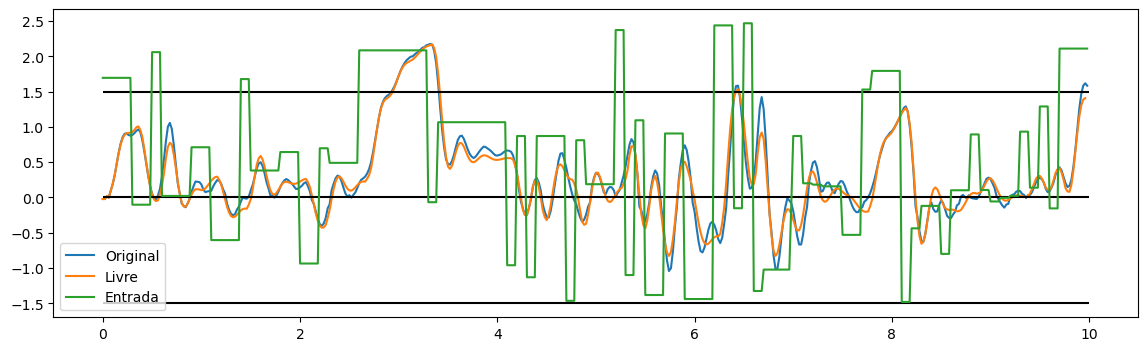


Um passo a frente
RMSE: 0.0417 
MSE: 0.0017 
AET: 13.5982 
MAPE: 40.605%
Coeficiente de correlação: 0.997569103039967

Simulação livre
RMSE: 0.1124 
MSE: 0.0126 
AET: 40.9181 
MAPE: 108.246%
Coeficiente de correlação: 0.9826060717489598


In [16]:
output = 0  # 0 ou 1

y = zc11.copy()
u = u11.copy()
num = [9, 6]
params = []
params.append({'nb':[6],'na':[8], 'level':3, 'nonlinear':[0,0,0,1,0], 'root':False, 'delay':0, 'diff':False}) #9

#params.append({'nb':[6],'na':[8], 'level':2, 'nonlinear':[0,0,0,1,0], 'root':False, 'delay':0, 'diff':False}) #9

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)

vCandidatos = sselector.matrix_candidate(u.T, y.T, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[pad:, output], num[output], 0.000001)
theta = LSM(y[pad:, output], psi)
model = ss[selected]

print(model, theta)
print(model @ np.round(theta, 5))

slivre = sselector.predict(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)
yhat = sselector.oneStepForward(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1, intg=False)


fim = -1
s = 0#t-20
ts = np.arange(0, 10, 0.02)
plt.figure(figsize=(14, 4))
plt.plot(ts, y, label='Original')
#plt.plot(ts[s:fim], yhat[s:fim], label='um passo a frente')
plt.plot(ts[s:fim], slivre[s:fim], label='Livre')
plt.hlines([1.5, 0, -1.5], 0, 10, colors='black')
plt.plot(ts, u, label='Entrada')
plt.legend()
plt.show()

print("\nUm passo a frente")
metrics(y[:, 0], yhat)
print("\nSimulação livre")
metrics(y[:, 0], slivre)

#Y1.1 Y1.2 Y1.4 U1.3 U1.4*Y1.1 Y1.3 Y1.6*tanh(Y1.1) U1.5*U1.6
#Y1.1 Y1.2 Y1.6 U1.3*U1.7**2 U1.4 Y1.3 U1.6*Y1.6 U1.1*U1.7*tanh(U1.1)

### Teste input

In [ ]:
plt.plot(uVal[0, :].T)
plt.show()

Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, Y1.5, Y1.6, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8]
Modelo selecionado:
                2                                                             
0.0064⋅U1.3⋅U1.7  + 0.0296⋅U1.4 + 0.0071⋅U1.5⋅U1.8⋅Y1.6 + 0.0188⋅U1.6 + 1.2748

                                                          
⋅Y1.1 - 0.5114⋅Y1.3 + 0.0384⋅Y1.6⋅tanh(Y1.1) + 0.1009⋅Y1.6


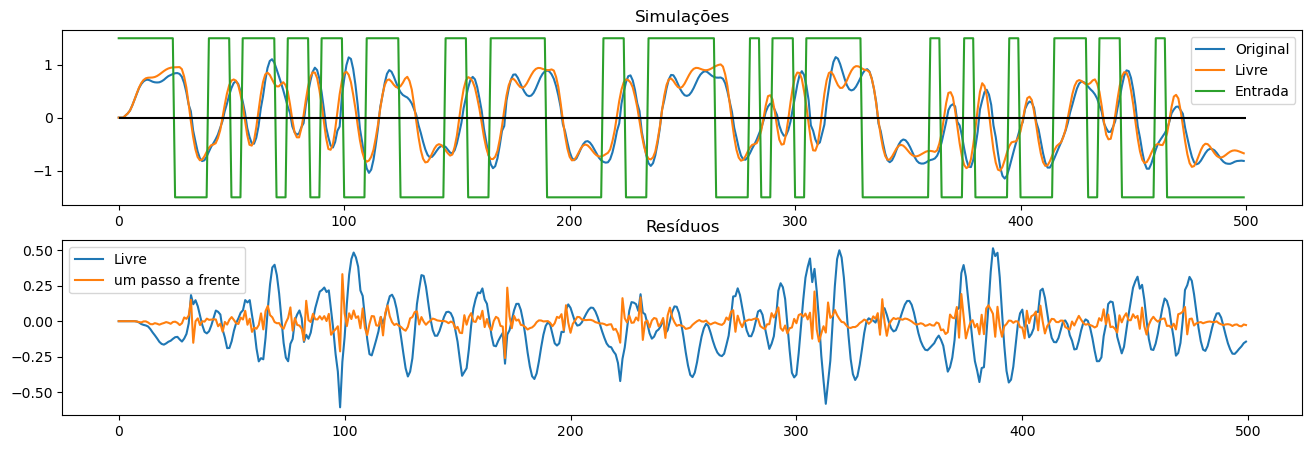


Um passo a frente
RMSE: 0.0543 
MSE: 0.0029 
AET: 18.6392 
MAPE: 14.719%
Coeficiente de correlação: 0.9960477244963499

Simulação livre
RMSE: 0.192 
MSE: 0.0369 
AET: 75.5414 
MAPE: 45.957%
Coeficiente de correlação: 0.9526043142349142


In [51]:
'''uVal = u11.copy().T
yVal = zc11.T
uVal[0, :-115] = uVal[0, 115:]
uVal[0, -115:] = 2
uVal[0, 420:] = -2
uVal[0, 450:] = 1
uVal[0, 480:] = 1'''
uVal = u1.copy().T
yVal = zc1.T

yValHat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)

print("Modelo selecionado:")
pprint( model @ np.round(theta, 4))

f, ax = plt.subplots(2, 1, figsize=[16,5])
ax[0].plot(yVal[output].T, label='Original')
ax[0].plot(valLivre, label='Livre')
ax[0].plot(uVal.T, label='Entrada')
#ax[0].plot(np.abs(valLivre), label='Livre')
#ax[0].plot(yhat, label='um passo a frente')
ax[0].hlines(0, 0, 500, colors='black')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - (valLivre), label='Livre')
ax[1].plot(yVal[output].T - (yValHat), label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

print("\nUm passo a frente")
metrics(yVal[0, :], (yValHat))
print("\nSimulação livre")
metrics(yVal[0, :], (valLivre))

### MAPE

In [ ]:
r = (z11[:, 0] - np.abs(yhat))
index = np.where(z11[:, 0] > 0.1)
ape = np.abs(r[index] / z11[index[0], 0])
mape = np.mean(ape)

print(round(mape*100, 5), np.mean(z11))
i = np.argmax(ape)
print(i, r[i] / z11[i, 0], r[i] , z11[i, 0], slivre[i])
#plt.plot(r[100:120])
plt.plot(ape)
plt.show()

coeficiente_hat = np.corrcoef(z11[:,0], np.abs(yhat))[0, 1]
coeficiente_livre = np.corrcoef(z11[:,0], np.abs(slivre))[0, 1]
print(coeficiente_hat, coeficiente_livre)

## Validação

In [ ]:
uVal = u12.T
yVal = z12.T

yValHat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)

print("Modelo selecionado:")
pprint( model @ np.round(theta, 4))

f, ax = plt.subplots(2, 1, figsize=[16,5])
ax[0].plot(yVal[output].T, label='Original')
#ax[0].plot(valLivre, label='Livre')
ax[0].plot(np.abs(valLivre), label='Livre')
#ax[0].plot(yhat, label='um passo a frente')
ax[0].hlines(0, 0, 500, colors='black')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - np.abs(valLivre), label='Livre')
ax[1].plot(yVal[output].T - np.abs(yValHat), label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

print("\nUm passo a frente")
metrics(yVal[0, :], np.abs(yValHat))
print("\nSimulação livre")
metrics(yVal[0, :], np.abs(valLivre))

In [ ]:
coeficiente_hat = np.corrcoef(z12[:,0], yValHat)[0, 1]
coeficiente_livre = np.corrcoef(z12[:,0], valLivre)[0, 1]
print(coeficiente_hat, coeficiente_livre)

In [ ]:
p = np.arange(0, 10, 0.02)

f, ax = plt.subplots(2, 1, figsize=[14, 8])
ax[0].plot(p, z11, label='Original')
ax[0].plot(p, np.abs(slivre), label='Simulação livre')
ax[0].set_ylabel('y11 (V)')
ax[0].set_ylim(-0.1, 4.1)
ax[0].set_title("Estimação")
ax[0].legend()

ax[1].plot(p, z12, label='Original')
ax[1].plot(p, np.abs(valLivre), label='Simulação livre')
ax[1].set_ylabel('y12 (V)')
ax[1].set_xlabel('t (s)')
ax[1].set_ylim(-0.1, 4.1)
ax[1].set_title("Validação")
ax[1].legend()

plt.tight_layout() 
plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Modelo TCC - Jonh lucas/figuras/coupledrivesResult.png')

plt.show()

## Teste

In [ ]:
uVal = u11.copy().T
yVal = z11.T
uVal[0, 20:30] = 2
uVal[0, 30:35] = -1
uVal[0, 35:40] = 1
uVal[0, 40:50] = 0.5
uVal[0, 70:90] = 1
uVal[0, 90:100] = -1
uVal[0, 100:110] = 1
uVal[0, 110:120] = -1
uVal[0, 120:] = 2

yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)

print("Modelo selecionado:")
pprint( model @ theta)

f, ax = plt.subplots(2, 1, figsize=[16,5])
ax[0].plot(uVal.T, label='Entrada')
#ax[0].plot(valLivre, label='Livre')
ax[0].plot(np.abs(valLivre), label='Livre')
#ax[0].plot(yhat, label='um passo a frente')
ax[0].hlines(0, 0, 500, colors='black')
ax[0].set_title("Simulações")
ax[0].legend()

ax[1].plot(yVal.T, label='Livre')
ax[1].plot(valLivre, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

print("\nSimulação livre")
metrics(yVal[0, :], np.abs(valLivre))
print("\nUm passo a frente")
metrics(yVal[0, :], np.abs(yhat))


## polinomial sem não linearidades adicionais

[Y1.1 Y1.2 U1.4*U1.7 Y1.4 U1.5**2 U1.3*U1.8*Y1.3] [ 1.74610425 -1.06689272  0.01624349  0.22131932  0.01763527  0.00791231]
0.00791*U1.3*U1.8*Y1.3 + 0.01624*U1.4*U1.7 + 0.01764*U1.5**2 + 1.7461*Y1.1 - 1.06689*Y1.2 + 0.22132*Y1.4
Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8]


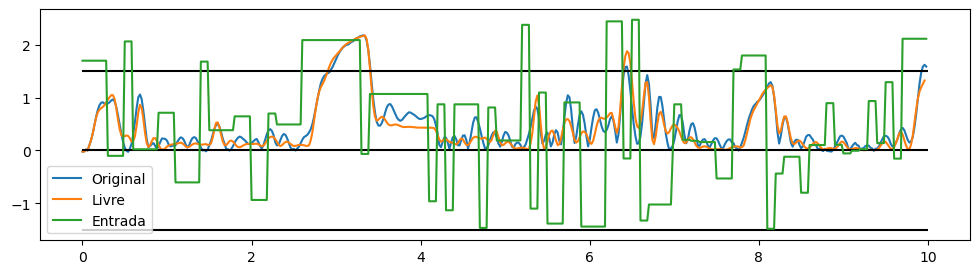


Simulação livre
RMSE: 0.1566 
MSE: 0.0245 
AET: 59.0619 
MAPE: 119.357%
Coeficiente de correlação: 0.9532297920378829

Um passo a frente
RMSE: 0.0442 
MSE: 0.002 
AET: 15.4019 
MAPE: 57.735%
Coeficiente de correlação: 0.9959410401599569
Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8]
Modelo selecionado:
                                                      2                       
0.0079⋅U1.3⋅U1.8⋅Y1.3 + 0.0162⋅U1.4⋅U1.7 + 0.0176⋅U1.5  + 1.7461⋅Y1.1 - 1.0669

                   
⋅Y1.2 + 0.2213⋅Y1.4


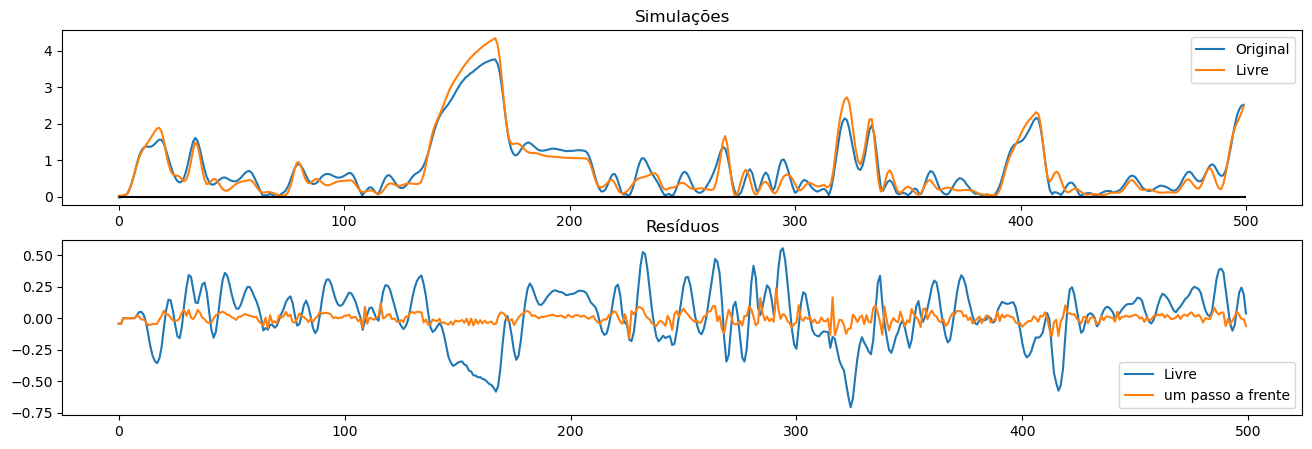


Simulação livre
RMSE: 0.2162 
MSE: 0.0467 
AET: 85.2616 
MAPE: 69.617%
Coeficiente de correlação: 0.9752508883963753

Um passo a frente
RMSE: 0.0425 
MSE: 0.0018 
AET: 15.7058 
MAPE: 28.507%
Coeficiente de correlação: 0.998640344524096


In [52]:
output = 0  # 0 ou 1

y = z11.copy()
u = u11.copy()
num = [8, 6]
params = []
params.append({'nb':[4],'na':[8], 'level':3, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':0, 'diff':False}) #9

#params.append({'nb':[6],'na':[8], 'level':2, 'nonlinear':[0,0,0,1,0], 'root':False, 'delay':0, 'diff':False}) #9

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)

vCandidatos = sselector.matrix_candidate(u.T, y.T, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[pad:, output], num[output], 0.000001)
theta = LSM(y[pad:, output], psi)
model = ss[selected]

print(model, theta)
print(model @ np.round(theta, 5))

polinomial_slivre = sselector.predict(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)
polinomial_yhat = sselector.oneStepForward(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1, intg=False)


fim = -1
s = 0#t-20
ts = np.arange(0, 10, 0.02)
plt.figure(figsize=(12,3))
plt.plot(ts, y, label='Original')
#plt.plot(ts[s:fim], yhat[s:fim], label='um passo a frente')
plt.plot(ts[s:fim], polinomial_slivre[s:fim], label='Livre')
plt.hlines([1.5, 0, -1.5], 0, 10, colors='black')
plt.plot(ts, u, label='Entrada')
plt.legend()
plt.show()

print("\nSimulação livre")
metrics(y[:, 0], polinomial_slivre)
print("\nUm passo a frente")
metrics(y[:, 0], polinomial_yhat)

uVal = u12.T
yVal = z12.T

polinomial_yValHat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
polinomial_valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)

print("Modelo selecionado:")
pprint( model @ np.round(theta, 4))

f, ax = plt.subplots(2, 1, figsize=[16,5])
ax[0].plot(yVal[output].T, label='Original')
#ax[0].plot(polinomial_valLivre, label='Livre')
ax[0].plot(np.abs(polinomial_valLivre), label='Livre')
#ax[0].plot(polinomial_yhat, label='um passo a frente')
ax[0].hlines(0, 0, 500, colors='black')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - np.abs(polinomial_valLivre), label='Livre')
ax[1].plot(yVal[output].T - np.abs(polinomial_yValHat), label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

print("\nSimulação livre")
metrics(yVal[0, :], np.abs(polinomial_valLivre))
print("\nUm passo a frente")
metrics(yVal[0, :], np.abs(polinomial_yValHat))


[Y1.1 U1.4 Y1.9 U1.3*U1.9**2 U1.6 U1.5*U1.6*Y1.10 Y1.3] [ 1.16543697  0.03169555  0.05274461  0.00925593  0.02913427  0.01203333
 -0.35820601]
0.00926*U1.3*U1.9**2 + 0.0317*U1.4 + 0.01203*U1.5*U1.6*Y1.10 + 0.02913*U1.6 + 1.16544*Y1.1 - 0.35821*Y1.3 + 0.05274*Y1.9
Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, Y1.5, Y1.6, Y1.7, Y1.8, Y1.9, Y1.10, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8, U1.9, U1.10]


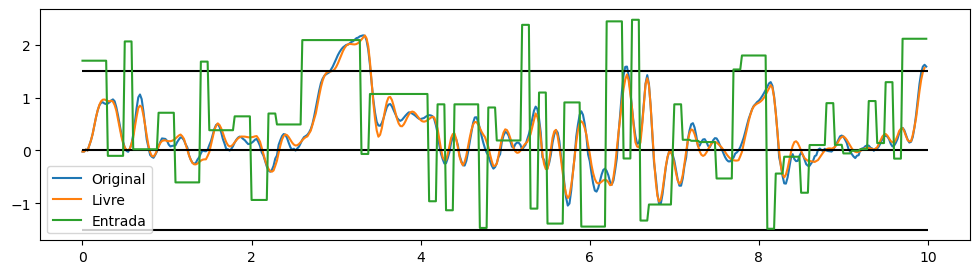


Simulação livre
RMSE: 0.0923 
MSE: 0.0085 
AET: 35.5904 
MAPE: 105.515%
Coeficiente de correlação: 0.9885873333931949

Um passo a frente
RMSE: 0.0396 
MSE: 0.0016 
AET: 13.4885 
MAPE: 39.867%
Coeficiente de correlação: 0.9978116915500871


In [53]:
output = 0  # 0 ou 1

y = zc11.copy()
u = u11.copy()
num = [8, 6]
params = []
params.append({'nb':[10],'na':[10], 'level':3, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':0, 'diff':False}) #9

#params.append({'nb':[6],'na':[8], 'level':2, 'nonlinear':[0,0,0,1,0], 'root':False, 'delay':0, 'diff':False}) #9

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)

vCandidatos = sselector.matrix_candidate(u.T, y.T, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[pad:, output], num[output], 0.000001)
theta = LSM(y[pad:, output], psi)
model = ss[selected]

print(model, theta)
print(model @ np.round(theta, 5))

polinomial_slivre = sselector.predict(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)
polinomial_yhat = sselector.oneStepForward(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1, intg=False)


fim = -1
s = 0#t-20
ts = np.arange(0, 10, 0.02)
plt.figure(figsize=(12,3))
plt.plot(ts, y, label='Original')
#plt.plot(ts[s:fim], yhat[s:fim], label='um passo a frente')
plt.plot(ts[s:fim], polinomial_slivre[s:fim], label='Livre')
plt.hlines([1.5, 0, -1.5], 0, 10, colors='black')
plt.plot(ts, u, label='Entrada')
plt.legend()
plt.show()

print("\nSimulação livre")
metrics(y[:, 0], polinomial_slivre)
print("\nUm passo a frente")
metrics(y[:, 0], polinomial_yhat)
#Y1.1 Y1.2 Y1.4 U1.3 U1.4*Y1.1 Y1.3 Y1.6*tanh(Y1.1) U1.5*U1.6
#Y1.1 Y1.2 Y1.6 U1.3*U1.7**2 U1.4 Y1.3 U1.6*Y1.6 U1.1*U1.7*tanh(U1.1)

Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, Y1.5, Y1.6, Y1.7, Y1.8, Y1.9, Y1.10, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8, U1.9, U1.10]
Modelo selecionado:
                2                                                             
0.0093⋅U1.3⋅U1.9  + 0.0317⋅U1.4 + 0.012⋅U1.5⋅U1.6⋅Y1.10 + 0.0291⋅U1.6 + 1.1654

                                 
⋅Y1.1 - 0.3582⋅Y1.3 + 0.0527⋅Y1.9


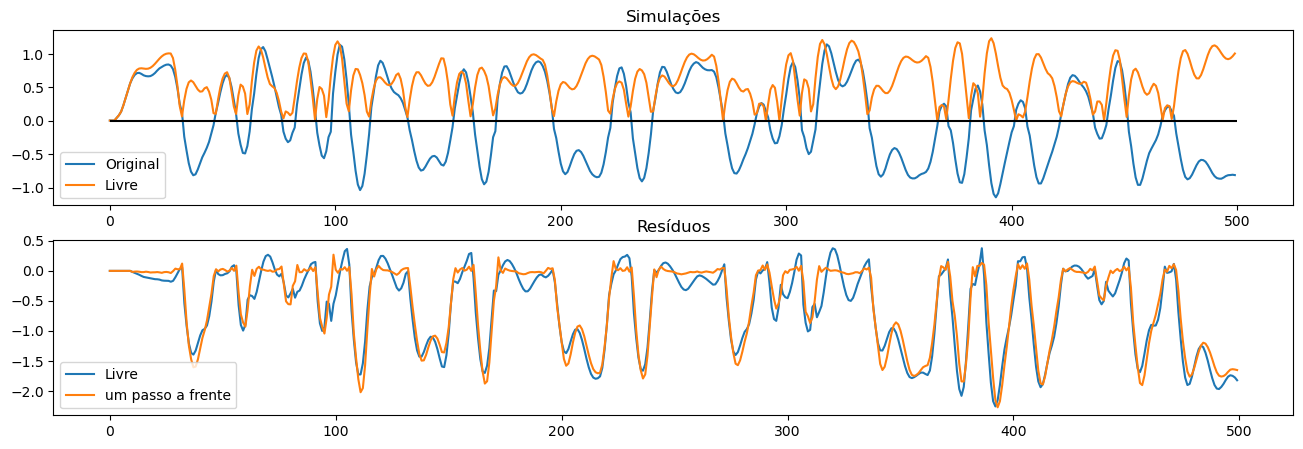


Simulação livre
RMSE: 0.8905 
MSE: 0.7929 
AET: 322.0203 
MAPE: 131.949%
Coeficiente de correlação: 0.04347101811318011

Um passo a frente
RMSE: 0.8522 
MSE: 0.7263 
AET: 277.9188 
MAPE: 103.031%
Coeficiente de correlação: 0.0135379528387564


In [55]:
'''uVal = u12.T
yVal = z12.T'''
uVal = u1.copy().T
yVal = zc1.T

polinomial_yValHat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
polinomial_valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)

print("Modelo selecionado:")
pprint( model @ np.round(theta, 4))

f, ax = plt.subplots(2, 1, figsize=[16,5])
ax[0].plot(yVal[output].T, label='Original')
#ax[0].plot(polinomial_valLivre, label='Livre')
ax[0].plot(np.abs(polinomial_valLivre), label='Livre')
#ax[0].plot(polinomial_yhat, label='um passo a frente')
ax[0].hlines(0, 0, 500, colors='black')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - np.abs(polinomial_valLivre), label='Livre')
ax[1].plot(yVal[output].T - np.abs(polinomial_yValHat), label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

print("\nSimulação livre")
metrics(yVal[0, :], np.abs(polinomial_valLivre))
print("\nUm passo a frente")
metrics(yVal[0, :], np.abs(polinomial_yValHat))


In [ ]:
p = np.arange(0, 10, 0.02)

f, ax = plt.subplots(2, 1, figsize=[14, 8])
ax[0].plot(p, z11, label='Original')
ax[0].plot(p, np.abs(slivre), label='Proposto')
ax[0].plot(p, np.abs(polinomial_slivre), label='Polinomial')

ax[0].set_ylabel('y11 (V)')
ax[0].set_ylim(-0.1, 4.1)
ax[0].set_title("Estimação")
ax[0].legend()

ax[1].plot(p, z12, label='Original')
ax[1].plot(p, np.abs(valLivre), label='Proposto')
ax[1].plot(p, np.abs(polinomial_valLivre), label='Polinimial')
ax[1].set_ylabel('y12 (V)')
ax[1].set_xlabel('t (s)')
ax[1].set_ylim(-0.1, 4.1)
ax[1].set_title("Validação")
ax[1].legend()

plt.tight_layout() 
plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Modelo TCC - Jonh lucas/figuras/coupledrivesComparate.png')

plt.show()

## Melhor resultado
Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, Y1.5, Y1.6, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8]
Modelo selecionado:
                                                                        2     
$$0.00766272998429804⋅U1.1⋅U1.7⋅tanh(U1.1) + 0.00463398651746354⋅U1.3⋅U1.7  + 
\\0.0295471369309655⋅U1.4 + 0.00520356242948974⋅U1.5⋅U1.8 + 0.0183656208296996⋅U1.6⋅Y1.6 + 
\\ 1.49070998933788⋅Y1.1 - 0.420884288405317⋅Y1.2 - 0.261528262737152⋅Y1.3 + 0.082456449579637⋅Y1.6$$
